# Activation Maximization

## Visualizing Conv filters

In [1]:
%reload_ext autoreload
%autoreload 2

import tensorflow as tf
from tf_keras_vis.utils import print_gpus

print_gpus()

1 Physical GPUs, 1 Logical GPU


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Visualizing Conv filters

ActivationMaximization will maximize the value that is computed by the loss function passed as argument. Here, we try to visualize conv filters. To do so, you need to replace the model output to arbitrary layer's output that contains target conv filters.

> [!NOTE]
> For visualizing these filters clearly and sharply, we recommend you using `SmoothedLoss`. Most of conv filters will be visualized well.

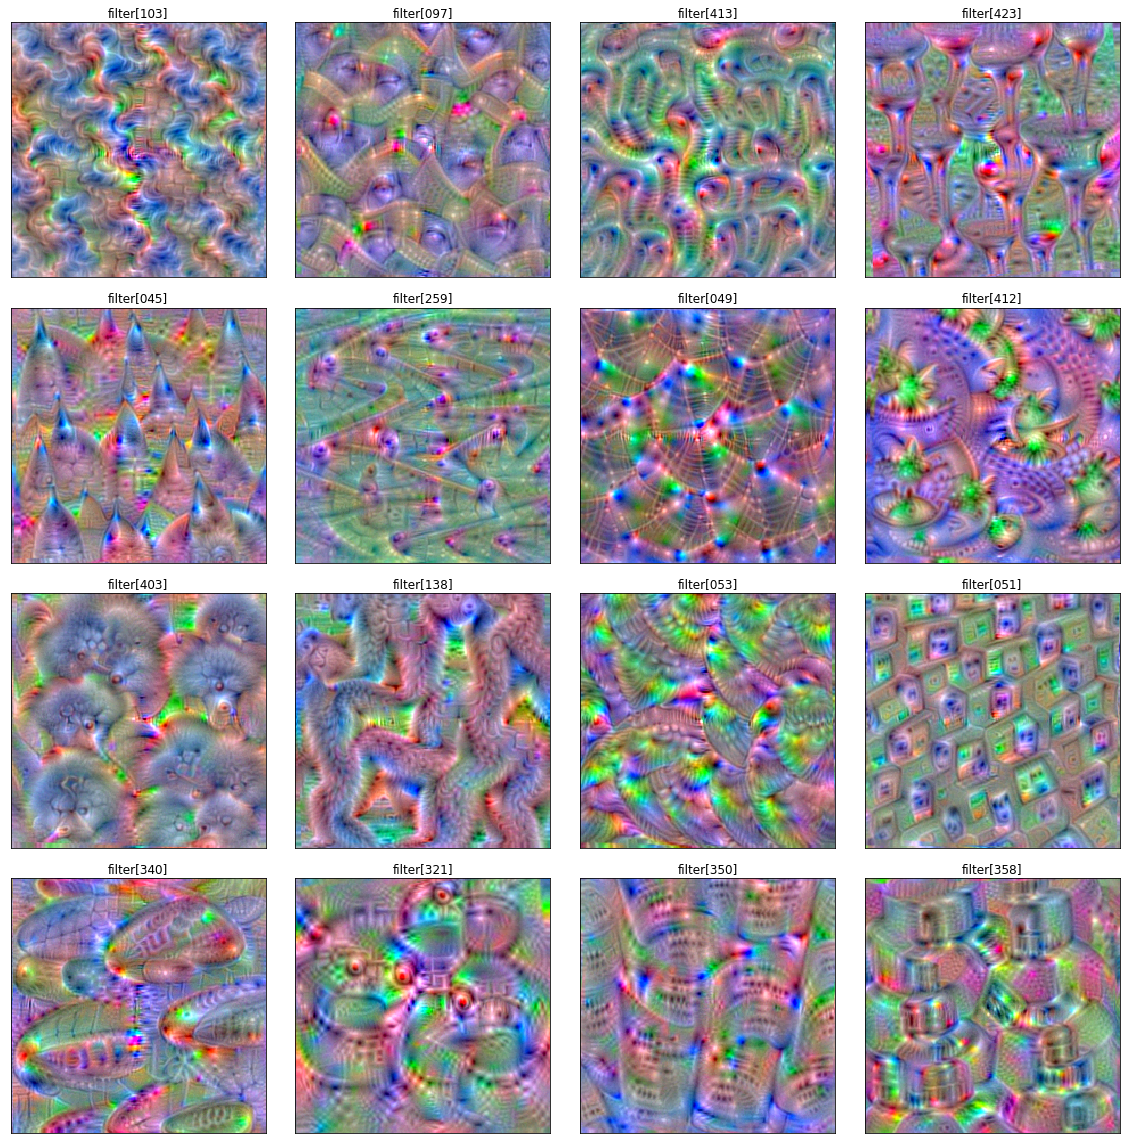

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.utils.losses import SmoothedLoss

# The target layer that is the last layer of VGG16.
layer_name = 'block5_conv3'

# Define modifier to replace the model output to target layer's output.
# You need to return new model when you create new model instance in model_modifier.
def model_modifier(m):
    new_model = tf.keras.Model(inputs=m.inputs, outputs=[m.get_layer(name=layer_name).output])
    new_model.layers[-1].activation = tf.keras.activations.linear
    return new_model

# Create Activation Maximization object
activation_maximization = ActivationMaximization(model, model_modifier)

num_of_filters = 16
filter_numbers = np.random.choice(model.get_layer(name=layer_name).output.shape[-1], num_of_filters)
cols = 4
rows = num_of_filters // cols
f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4), subplot_kw={'xticks': [], 'yticks': []})

for i, filter_number in enumerate(filter_numbers):
    # Define loss function that is sum of a filter output.
    loss = SmoothedLoss(filter_number)

    # Generate max activation
    activation = activation_maximization(loss)
    image = activation[0].astype(np.uint8)

    ax[i // cols][i % cols].imshow(image)
    ax[i // cols][i % cols].set_title('filter[{:03d}]'.format(filter_number))

plt.tight_layout()
plt.show()